In [1]:
from __future__ import print_function, division, absolute_import
from six.moves import cPickle as pickle

In [2]:
import os, time

import numpy as np

import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

### Loading the data

In [4]:
image_size = 28
pixel_depth = 255
data_root = 'data'

In [5]:
pickle_file  = os.path.join(data_root, 'notMNIST.pickle')
keys = ["{0}_{1}".format(t,x) for t in ["train","test"] for x in "Xy"]+["labels_dict"]
with open(pickle_file, 'rb') as f:
    pi = pickle.load(f)
    for k in keys:
        globals()[k] = pi[k]
print(train_X.shape, test_X.shape)

(529114, 784) (18724, 784)


In [6]:
nclasses = len(labels_dict)
labels_dict

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9}

In [7]:
def to_onehot(labels, nclasses):
    onehot = np.zeros(shape=(len(labels), nclasses))
    for i, label in enumerate(labels):
        onehot[i, int(label)] = 1
    return onehot

test_y = to_onehot(test_y, nclasses)

In [8]:
def generate_batch(batch_size=10):
    global train_X, train_y, labels_dict
    j = 0
    while 1:
        i = j
        if i+batch_size < len(train_X):
            j = i + batch_size
            raw_labels = train_y[i:i+batch_size]
            yield train_X[i:i+batch_size], to_onehot(raw_labels.flatten(), len(labels_dict))
        else:
            j = 0
            raw_labels = np.concatenate((train_y[i:], train_y[0:batch_size-(len(train_y)-i)]))
            yield np.concatenate((train_X[i:], train_X[0:batch_size-(len(train_X)-i)])),\
                    to_onehot(raw_labels.flatten(), len(labels_dict))
        

In [9]:
img_size = 28
in_depth = 1  # gray scale
out_depth = 16
kernel_size = 5
hsize = 64
batch_size = 1000

In [10]:
train_X = train_X.reshape((train_X.shape[0], img_size, img_size, in_depth))
train_X.shape

(529114, 28, 28, 1)

In [11]:
test_X = test_X.reshape((test_X.shape[0], img_size, img_size, in_depth))
test_X.shape

(18724, 28, 28, 1)

### LeNet

In [12]:
graph = tf.Graph()
with graph.as_default():
    with tf.name_scope("inputs"):
        train_inputs = tf.placeholder(tf.float32, shape=[batch_size, image_size,image_size, in_depth])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, nclasses])
        beta = tf.placeholder("float")
        alpha = tf.placeholder("float")
        
    with tf.name_scope("Weights"):
        l1_w = tf.Variable(
            tf.truncated_normal([kernel_size, kernel_size, in_depth, out_depth],stddev=0.1)
        )
        l1_b = tf.Variable(
            tf.zeros([out_depth])
        )
        
        
        l2_w = tf.Variable(
            tf.truncated_normal([kernel_size, kernel_size, out_depth, out_depth],stddev=0.1)
        )
        l2_b = tf.Variable(
            tf.zeros([out_depth])
        )
        
        l3_w = tf.Variable(
            tf.truncated_normal([img_size//4 * img_size//4 *out_depth, hsize],stddev=0.1)
        )
        l3_b = tf.Variable(
            tf.zeros([hsize])
        )
        
        l4_w = tf.Variable(
            tf.truncated_normal([hsize, hsize],stddev=0.1)
        )
        l4_b = tf.Variable(
            tf.zeros([hsize])
        )
        
        l5_w = tf.Variable(
            tf.truncated_normal([hsize, nclasses],stddev=0.1)
        )
        l5_b = tf.Variable(
            tf.zeros([nclasses])
        )
        
        
    with tf.name_scope("convulotion"):
        def model(data, keep=0.5):
            ## conv1
            conv = tf.nn.conv2d(data, l1_w, [1,2,2,1], padding='SAME')
            
            ## maxpooling 1
            pool = tf.nn.pool(conv, [kernel_size, kernel_size], pooling_type="MAX", padding='SAME')
            hidden = tf.nn.relu(pool+l1_b)
            
            ## conv2
            conv = tf.nn.conv2d(hidden, l2_w, [1,2,2,1], padding='SAME')
            
            ## maxpooling 2
            pool = tf.nn.pool(conv, [kernel_size, kernel_size], pooling_type="MAX", padding='SAME')
            hidden = tf.nn.relu(pool+l2_b)
            
            
            shapes = hidden.get_shape().as_list()
            reshape = tf.reshape(hidden, [tf.shape(hidden)[0], shapes[1]*shapes[2]*shapes[3]])
            
            ## fully connected 1
            hidden = tf.nn.dropout(tf.nn.relu(tf.matmul(reshape, l3_w)+l3_b), keep)
            
            ## fully connected 2
            hidden = tf.nn.dropout(tf.nn.relu(tf.add(tf.matmul(hidden, l4_w), l4_b)), keep)
            
            logits = tf.add(tf.matmul(hidden, l5_w), l5_b)
            return logits
        
    logits = model(train_inputs) 
    
    with tf.name_scope("Loss"):
        cross_entropy_ = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=train_labels))
    
    with tf.name_scope("regularization"):
        regularizer = tf.nn.l2_loss(cross_entropy_)
        cross_entropy = tf.reduce_mean(tf.add(cross_entropy_, tf.multiply(beta, regularizer)))
    
    with tf.name_scope("Optimizer"):
        
        optimizer = tf.train.GradientDescentOptimizer(alpha).minimize(cross_entropy)
        
    with tf.name_scope("Predictions"):
        test_inputs = tf.placeholder(tf.float32, shape=[None, image_size,image_size, in_depth])
        test_labels = tf.placeholder(tf.int32, shape=[None, nclasses])
        test_logits = model(test_inputs, keep=1.0)
        prediction_probs = tf.nn.softmax(test_logits)
        predictions = tf.argmax(prediction_probs, 1)
        
    with tf.name_scope("Accuracy"):
        target = tf.argmax(test_labels, 1)
        correct = tf.equal(predictions, target)
        accuracy = tf.reduce_mean(tf.cast(correct, "float"))
    init = tf.global_variables_initializer()
    

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [13]:
def run_session(graph, epochs, learning_rate, beta_input, batch_size):
    start = time.time()
    accuracies = dict()
    losses = dict()
    batches = generate_batch(batch_size=batch_size)

    with tf.Session(graph=graph) as sess:
        with tf.device("/gpu"):
            init.run()
            print("Variables initialized")
            average_loss = 0
            for e in range(epochs+1):
                batch_X, batch_y = batches.__next__()
                feed_dict = {train_inputs:batch_X, train_labels:batch_y, beta:beta_input,alpha:learning_rate}
                _, loss = sess.run([optimizer, cross_entropy], feed_dict=feed_dict)
                average_loss += np.mean(loss)
#                 if e%10:
#                     learning_rate *=0.9
#                     beta_input *= 1.1
                if e%100 == 0:
                    print("Epoch {0}\nCross-entropy loss: {1}".format(e,average_loss/100 if e>0 else average_loss))
                losses[e] = average_loss
                average_loss = 0
                accuracy_ = sess.run([accuracy], feed_dict={test_inputs:test_X, test_labels:test_y})
                accuracy_ = np.mean(accuracy_)
                accuracies[e] = accuracy_
                if e%100 == 0:
                    print("Accuracy:{0}".format(accuracy_))
                    print("~"*40)
    print("Took: {}".format(time.time()-start))

    fig, ax1 = plt.subplots(figsize=(12,7))
    xticks = sorted(accuracies.keys())
    data1 = [accuracies[i] for i in xticks]
    data2 = [losses[i] for i in xticks]

    color = 'tab:blue'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy', color=color)
    ax1.plot(xticks, data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Cross-entropy loss', color=color)
    ax2.plot(xticks, data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

Variables initialized
Epoch 0
Cross-entropy loss: 3.291558265686035
Accuracy:0.1105533018708229
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 100
Cross-entropy loss: 0.02261941909790039
Accuracy:0.35863062739372253
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 200
Cross-entropy loss: 0.021782653331756593
Accuracy:0.4421063959598541
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 300
Cross-entropy loss: 0.019795174598693847
Accuracy:0.47762230038642883
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 400
Cross-entropy loss: 0.018603677749633788
Accuracy:0.5619525909423828
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 500
Cross-entropy loss: 0.017135478258132934
Accuracy:0.650128185749054
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 600
Cross-entropy loss: 0.015578091144561768
Accuracy:0.7113864421844482
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 700
Cross-entropy loss: 0.015008234977722168
Accuracy:0.7548600435256958
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 800
Cross-entropy

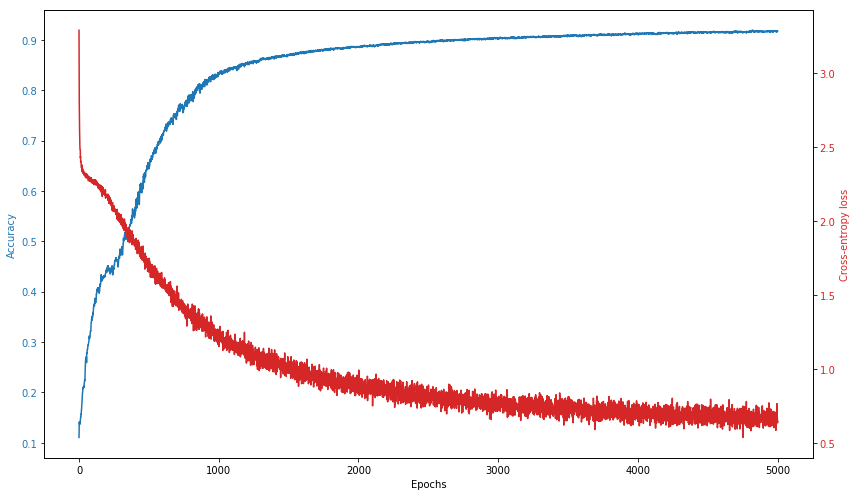

In [14]:
epochs = 5000
learning_rate = 0.01
beta_input = 0.01
batch_size = 1000

run_session(graph, epochs, learning_rate, beta_input, batch_size)